## Discretización con árboles de decisión

Este tipo de discretización consiste en usar árboles de decisión para identificar el número óptimo de intervalos. Cuando un árbol  toma una decisión, asigna una observación a uno de los n nodos. Por lo tanto, cualquier árbol de decisión generará un resultado discreto, cuyos valores son las predicciones en cada uno de sus n nodos

Cómo discretizar con árboles?

- 1) Entrenar con un árbol de decisión de una profundidad limitada (2, 3  o 4) usando la variable que queremos discretizar y el target.
 - 2) Reemplazar los valores por el resultado devuelto por el árbol 

### Ventajas

- El resultado retornado por el árbol de decisión esta monotónicamente relacionado con el target.
- Los nodos finales del árbol o los intervalos de la variable discretizada muestran una disminución en la entropía; eso es, las observaciones en cada intervalo son similares entre ellas y los demás intervalos. 

### Limitaciones

- Tendencia a sobre-ajustes
- Más importante, se requiere de ciertos ajustes en los parámetros de los árboles para obtener el número óptimo de divisiones ( e.j.: profundidad del árbol, mínimo número de muestras por nodo, número de nodos, etc). Esto puede tomar un tiempo considerable.

## En este demo

Aprenderás como discretizar con los árboles de decisión usando los datos del Titanic 

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# cargar variables numéricas Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols = ['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# separemos sets entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

Las variables age y fare contienen datos faltantes. Los vamos a completar extrayendo una muestra aleatoria de la variable.

In [4]:
def impute_na(data, variable):
    
    # función para reemplazar NA con una muestra aleatoria

    df = data.copy()

    # muestra aleatoria
    df[variable+'_aleatoria'] = df[variable]

     # extraer muestra aleatoria para completar datos faltantes na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas necesita tener el mismo index para poder 
    # combinar los dataframes
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_aleatoria'] = random_sample

    return df[variable+'_aleatoria']

In [5]:
# reemplazar los NA en sets de entrenamiento y prueba

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

### Age

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,21.0,7.7250
686,22.0,7.7250


In [7]:
# ejemplo: construir un árbol de clasificación usando la variable age para predecir 
# el target survival - supervivencia del titanic

tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['age_arbol'] = tree_model.predict_proba(X_train['age'].to_frame())[:,1]

X_train.head(10)

,age,fare,age_arbol
501,13.0,19.5000,0.366059
588,4.0,23.0000,0.529412
402,30.0,13.8583,0.366059
1193,21.0,7.7250,0.366059
686,22.0,7.7250,0.366059
971,16.0,7.8792,0.366059
117,30.0,56.9292,0.366059
540,2.0,26.0000,0.529412
294,49.0,110.8833,0.450704
261,35.0,26.2875,0.366059


In [8]:
# exploremos cuantos nodos el árbol creo
X_train['age_arbol'].unique()

array([0.36605891, 0.52941176, 0.45070423, 0.        , 1.        ])

Un árbol de profundidad 2, hace 2 divisiones, por lo tanto genera 4 intervalos, por eso vemos 4 probabilidades diferentes en el resultado anterior.

Text(0, 0.5, 'Survived')

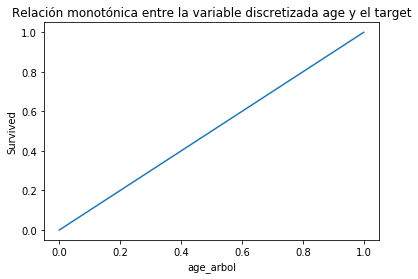

In [9]:
# Relación monotónica con el target

pd.concat([X_train, y_train], axis=1).groupby(['age_arbol'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

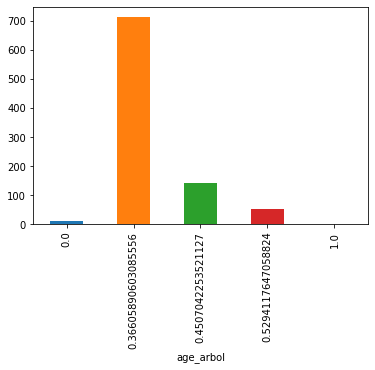

In [10]:
# número de pasajeros por intervalo de probabilidad
X_train.groupby(['age_arbol'])['age'].count().plot.bar()

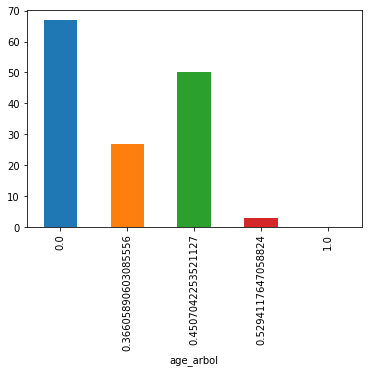

In [11]:
# Mediana de la variable age en cada uno de los intervalos
# creados por el árbol

X_train.groupby(['age_arbol'])['age'].median().plot.bar()

In [12]:
# veamos ahora los límites de la variable age generados
# por el árbol capturando el mínimo y máximo valor de edad por cada 
# intervalo de probabilidad, 
# esto nos da una idea de los límites de los intervalos

pd.concat( [X_train.groupby(['age_arbol'])['age'].min(),
            X_train.groupby(['age_arbol'])['age'].max()], axis=1)

,age,age
age_arbol,,
0.000000,65.0000,74.0000
0.366059,9.0000,44.0000
0.450704,45.0000,64.0000
0.529412,0.7500,8.0000
1.000000,0.1667,0.1667


Por lo tanto, el árbol de decisión generó los intervalos: 65-74, 9-44, 45-64, 0.7-8 y 0-16-0.16, con las probabilides de supervivencia de  .0, .36, .45, .52 y .1 respectivamente.

### Visualización árbol 

In [13]:
# podemos continuar y visualizar el árbol para guardar el
# modelo en un archivo y abrirlo con el enlace dedicado abajo

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# sigue este enlace para abril el archivo: http://webgraphviz.com

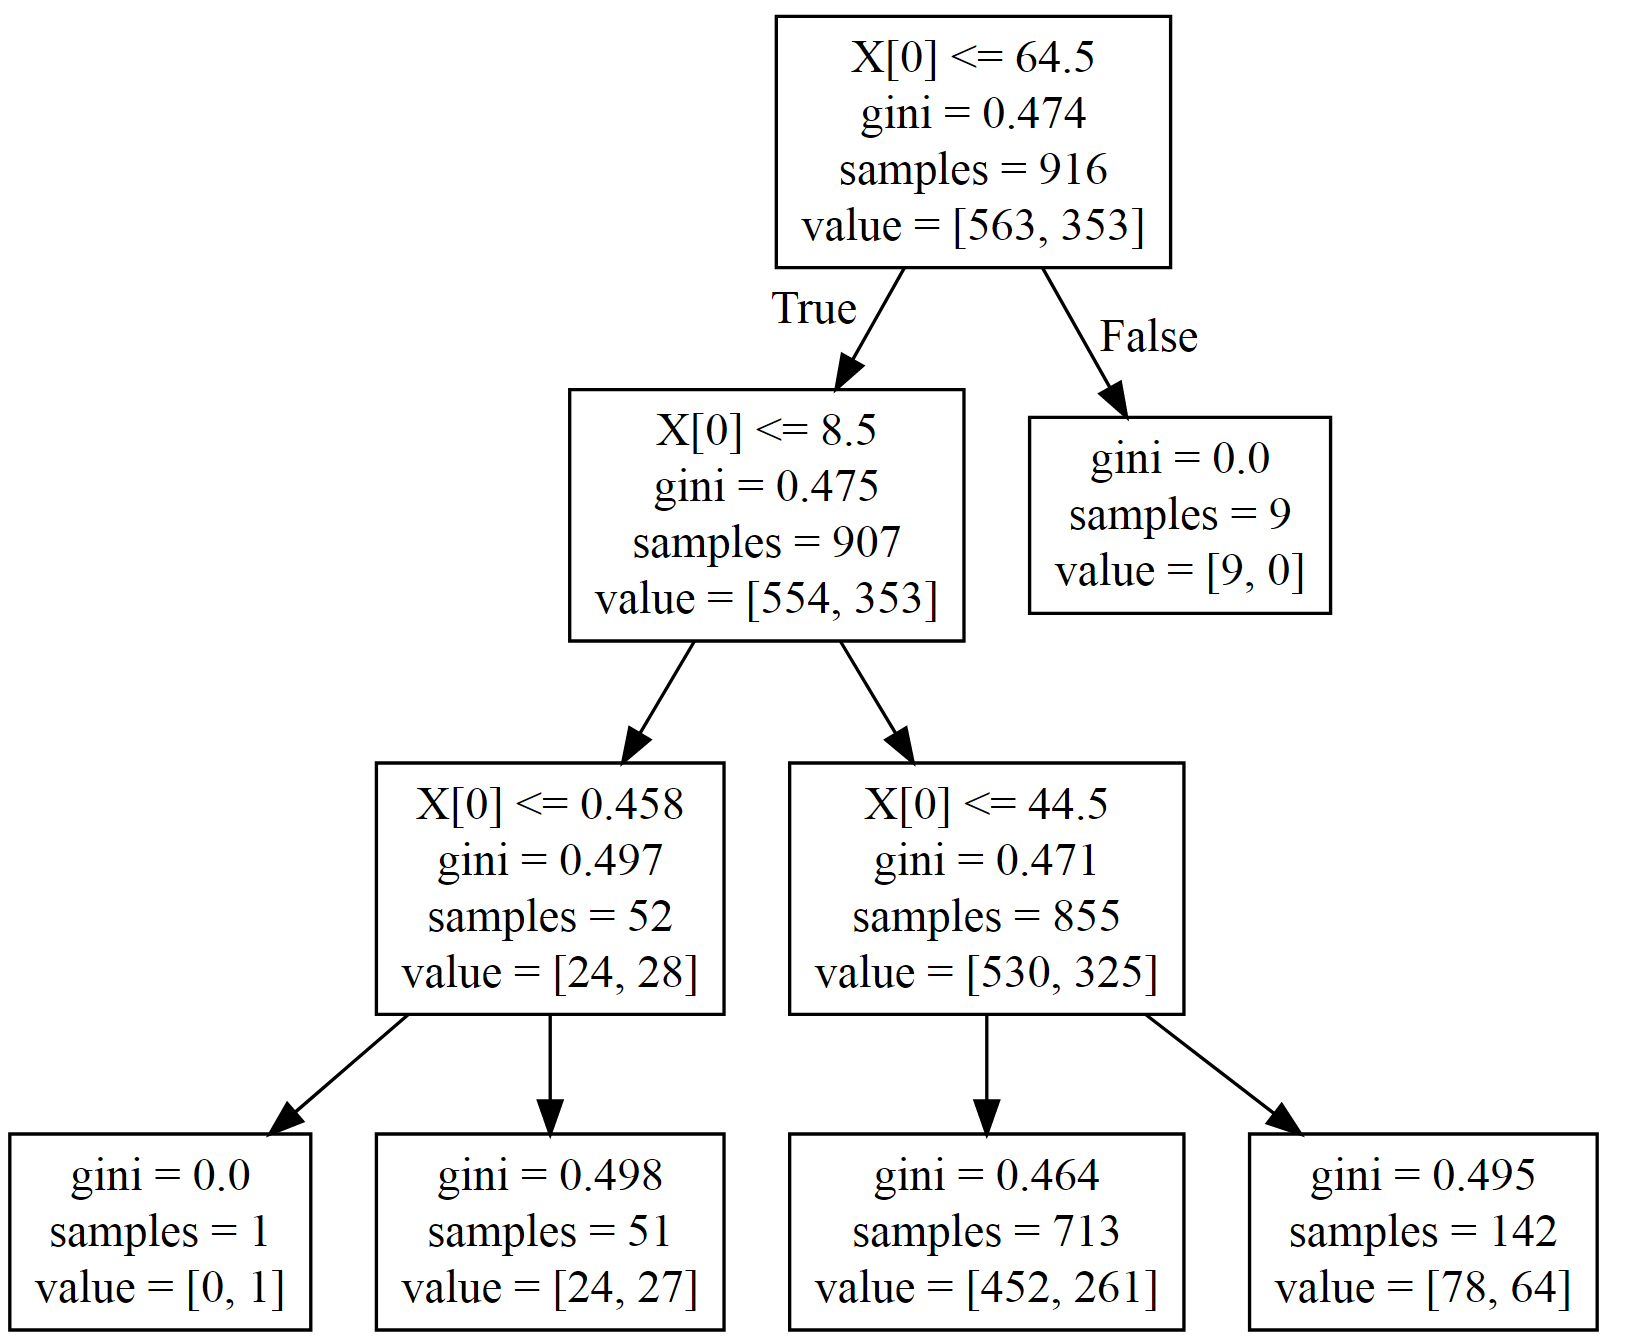

In [14]:
# esto es lo que deberías ver si sigues las instrucciones
# de la celda anterior

# Guardamos la imagen que debes obtener del servidor anterior
# en un png, y luego lo cargamos aquí para facilitar el demo

# la gráfica indica los límites de la variable age en cada nodo
# y también el número de muestras, y el valor de entropía gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)

**Expandamos los resultados del árbol al set de prueba, y exploramos la relación monotónica**

Text(0, 0.5, 'Survived')

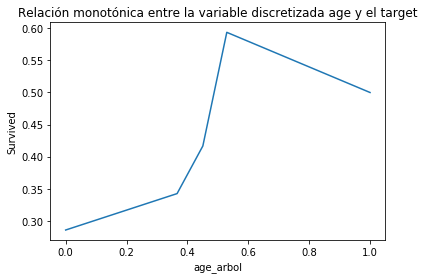

In [15]:
X_test['age_arbol'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# relación monotónica con el target

pd.concat([X_test, y_test], axis=1).groupby(['age_arbol'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

Podemos ver que la relación monotónica no es mantenida en el set de prueba, lo cual probablemente indica que el árbol que construimos esta sobre-ajustando el set de entrenamiento.

### Construyendo un árbol de decisión óptimo

Hay un número de parámetros que podriamos opmitizar para obtener la mejor división de intervalos usando árboles de decisión.

Vamos a optimizar la profundidad del árbol para esta demostración. Pero recuerda que podriamos también optimizar los demás parámetros del árbol. 

Visita [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) para ver que otros parámetros pueden ser optimizados.

In [16]:
# Construye árboles de diferentes profundidades, y calculemos
# el roc-auc por cada árbol
# escoge la profundidad que genera la mejor roc-auc

score_ls = []  # aqui guardamos la roc auc
score_std_ls = []  # aqui guardamos la desviación estandard del roc_auc

for tree_depth in [1, 2, 3, 4]:

    # llama el modelo
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # entrena el model usando validación cruzada 
    scores = cross_val_score(
        tree_model, X_train['age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    
    # guarda los parámetros 
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# captura los parámetros en un dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['profundidad', 'media_roc_auc', 'std_roc_auc']
temp

,profundidad,media_roc_auc,std_roc_auc
0,1,0.501463,0.010976
1,2,0.526206,0.017810
2,3,0.516446,0.028972
3,4,0.527593,0.023505


Obtenemos el mejor roc-auc usando profundidades de 2 (el mismo valor que profunidad 4 pero más pequeña desviación estándar std). Seleccionaremos una profundidad de 2 para continuar:

### Transformar las variables usando el árbol

In [17]:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['age_arbol'] = tree_model.predict_proba(X_train['age'].to_frame())[:, 1]
X_test['age_arbol'] = tree_model.predict_proba(X_test['age'].to_frame())[:, 1]

Text(0, 0.5, 'Survived')

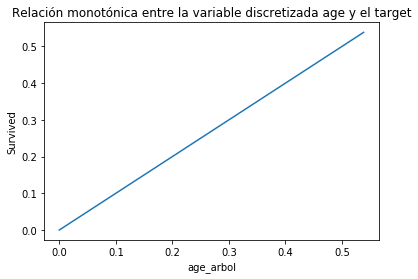

In [18]:
# Relación monotónica con el target en el set de entrenamiento

pd.concat([X_train, y_train], axis=1).groupby(['age_arbol'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

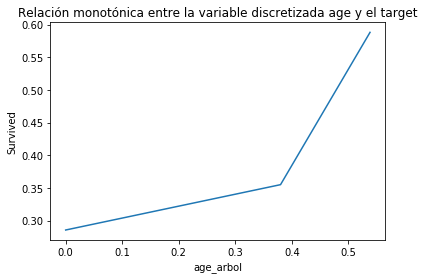

In [19]:
# y en el set de prueba

X_test['age_arbol'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# Relación monotónica con el target 

pd.concat([X_test, y_test], axis=1).groupby(['age_arbol'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

Ahora la relación monotónica con el target es mantenida con el set de prueba también.